# CS 440 Final Project: Clickbait Detection

### Team Members: Joshua Burris, Caleb Tong

In [5]:
# Global variables:
train_clickbait_file = 'train/train_clickbait.txt'
train_nonclickbait_file = 'train/train_nonclickbait.txt'
test_clickbait_file = 'test/test_clickbait.txt'
test_nonclickbait_file = 'test/test_nonclickbait.txt'

## Introduction

Clickbait spam is becoming an increasingly prevalent issue in society. Clickbait articles are uninformative, clutter websites with distracting content, and are an overall nuisance to the casual user. While clickbait has thrived thanks to eye-catching headlines that people can’t seem to resist, an increasing number of people are looking for ways to outright block it from their day-to-day websites.

Our project seeks to investigate ways of identifying these clickbait headlines to potentially hide them from users seeking a more pleasant browsing experience. And the goal we are hoping to achieve is to be able to take any given news headline as input and tell us, with a level of certainty, whether or not the article is clickbait. We believe this is an important task because clickbait websites do nothing more than distract readers with curious headlines and offer nothing of substance in return. They are tricking people into believing their content is better than it actually is. A tool which takes a headline and tells whether or not it is clickbait could also be useful to developers in particular. Implemented as an API, this could be used by browser plugin developers to actively hide or flag clickbait without needing to build or buy their own model and backend system to support it.

Telling the difference between a legitimate and a clickbait headline is not an easy task, so we built an n-gram language model that can calculate the perplexity of any given headline compared to a model trained on a big dataset of headlines. To do this we are going to need sufficiently large datasets of news article headlines that we know to be clickbait and know not to be clickbait in order to build the most accurate predictions we can. We are also going to compare the accuracy of using unigrams, bigrams, and trigrams to compute a clickbait percentage to see which yields the most accurate results.

## Defining Clickbait

In essence, we define a clickbait article headline to be one that entices people with curiosity or intrigue to click on the article, but doesn't contain any real information or substance in the article itself as to what the headline advertised. They're extremely easy to find if you go to almost any website with advertisements. These headlines can be easy to identify if you've ever fallen for one of them.

## Language Model

Our language model class is designed to be usable for unigrams, bigrams, and trigrams (our n-grams) depending on which <code>ngram</code> value you give the initializer. The first step to using our model is by training it on a piece of text, or in our case a large collection of clickbait article headlines. This is done through the <code>train</code> function, which takes a string as input and breaks it up into individual sentences and calculates our list of n-grams if they are needed. We can now get a perplexity value for any article headline simply by giving it to the <code>test</code> function. This perplexity value tells us how similar our test sentence was to the set of headlines we trained. We calculate our perplexity value by multiplying the probability of the sentence by $\frac{-1}{n}$, given by the equation below. $W$ is the whole sentence, $w_i$ is an individual word, and $n$ is the total number of words.

$$ PP(W)=P(w_1,w_2,w_3,...,w_n)^\frac{-1}{n} $$

To calculate the probability of a list of words we can use what's called the Markov assumption because the real calculation would take a lot longer. This approximation is calculated to be the sum of the probability of each individual word compared to an n-gram number of words that come before it. The equation looks like: where $k$ is the n-gram


$$ P(w_1,w_2,w_3,...,w_n) \approx \sum_i P(w_i | w_{i-k},...,w_{i-1}) $$

We also need to define that the probability of a single word compared to its n-gram is the frequency of the word combined with its n-gram divided by the frequency of the n-gram: where $c(w)$ is the frequency of an n-gram $w$.

$$ P(w_i|w_{i-k},...,w_{i-1}) = \frac{c(w_{i-k},...,w_{i-1},w_i)}{c(w_{i-1})} $$


In [6]:
import math, string
from collections import Counter

class language_model:
    def __init__(self, ngram=1) :
        self.ngram = ngram
    
    def train(self, text) :
        sentences = self.get_sentences(text)
        
        self.unigrams = Counter()
        for s in sentences :
            for w in s.split() :
                self.unigrams[w] += 1
        self.V = len(self.unigrams)
        self.total_count = sum(self.unigrams.values())
        
        if self.ngram > 1:
            self.bigrams = Counter()
            for s in sentences :
                words = s.split()
                for i in range(len(words) - 1):
                    self.bigrams[words[i] +' '+ words[i+1]] += 1
            self.V = len(self.bigrams)
            self.total_count = sum(self.bigrams.values())
        
        if self.ngram > 2:
            self.trigrams = Counter()
            for s in sentences :
                words = s.split()
                for i in range(len(words) - 2):
                    self.trigrams[words[i] +' '+ words[i+1] +' '+ words[i+2]] += 1
            self.V = len(self.trigrams)
            self.total_count = sum(self.trigrams.values())
    
    def test(self, text) :
        sentences = self.get_sentences(text)
        
        non_entries = 0
        entries = 0
        for s in sentences :
            words = s.split()
            for i in range(len(words) - (self.ngram - 1)) :
                gram = ' '.join(words[i:i+self.ngram])
                if self.count([gram]) :
                    non_entries += 1
                entries += 1
        
        self.sparsity = non_entries / entries
        
        return self.perplexity(sentences)
    
    def perplexity(self, sentences):
        return math.pow(2, self.entropy(sentences))
    
    def entropy(self, sentences):
        e = 0
        offset = self.ngram - 1
        length = 0
        for s in sentences :
            words = s.split()
            length += len(words)
            for i in range(offset, len(words)) :
                context = words[i - offset : i]
                e += -math.log(self.probability(words[i], context), 2)  
        return e / length
    
    def probability(self, word, context):
        return (self.count(context + [word]) + 1) / (self.count(context) + self.V)
    
    def count(self, context):
        size = len(context)
        words = ' '.join(context)
        if size == 1: return self.unigrams.setdefault(words, 0)
        if size == 2: return self.bigrams.setdefault(words, 0)
        if size == 3: return self.trigrams.setdefault(words, 0)
        return 0
    
    def get_sentences(self, text):
        
        sentences = []
        
        lines = text.split('\n')
        
        for l in lines :
            l = l.lower()
            l = l.translate(str.maketrans('?:!-', '... ', string.punctuation.replace('.', '')))
            l = ' '.join(l.split())
            
            new_line = ''
            for i in range(len(l)) :
                if l[i] == '.' and i != len(l) - 1 and l[i+1] != ' ' :
                    continue
                else :
                    new_line += l[i]
            l = new_line
            
            for s in l.split('.') :
                s = s.strip()
                if s :
                    sentences.append('<s> '+ s +' </s>')
        
        return sentences

## Calculating Clickbait Percentage

In order to determine if a headline is clickbait or not we decided to use two perplexity values. The first is our headline tested against our clickbait model, and the second is our headline tested against our non-clickbait model. Because these values can tell us how similar our headline is to either model, whichever perplexity value was lowest will tell us that that model is the most similar to our headline. We then want to determine a percentage for how much we think our headline fits in its model compared to the other one. Percentage was calculated to be one minus whichever perplexity was lowest, over the sum of both perplexities. Then in order to get this in a real percentage format we multiply that number by 100. In the equation $PP(L)$ is the lower of the two perplexities, and $PP(H)$ is the higher of the two:


$$
Percentage(W)=100 \times \big(1 - \frac{PP(L)}{PP(L) + PP(H)} \big)
$$


In [7]:
def is_clickbait(article_headline, c_model, nc_model) :
    c_perp = c_model.test(article_headline)
    nc_perp = nc_model.test(article_headline)
    
    if c_perp <= nc_perp :
        return True, 100*( 1-(c_perp/(c_perp+nc_perp)) )
    else :
        return False, 100*( 1-(nc_perp/(c_perp+nc_perp)) )

## N-gram Accuracy

In order to determine the accuracy of each n-gram we ran our testing datasets of clickbait and non-clickbait headlines against our trained models to see what percentage of our tests got the correct ourcome. We then plotted this on graphs so that you could see what the average perplexity value our test data came out to for each model. 

N-gram: 1
Clickbait accuracy: 95.49%
Non-clickbait accuracy: 77.48%
Average accuracy: 86.48%


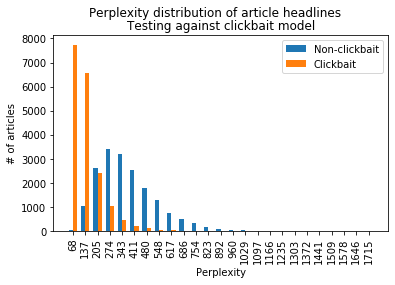

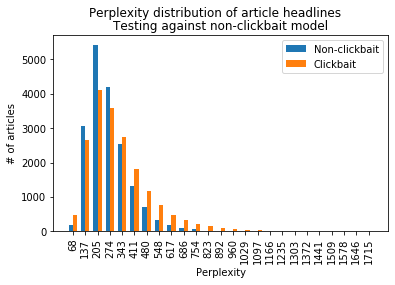

N-gram: 2
Clickbait accuracy: 94.45%
Non-clickbait accuracy: 55.30%
Average accuracy: 74.88%


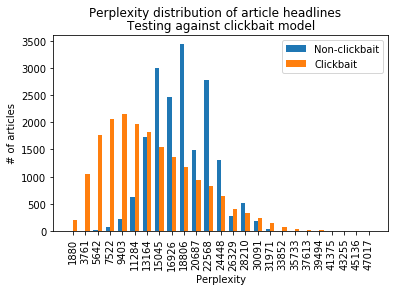

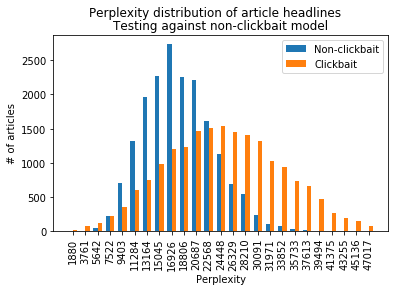

N-gram: 3
Clickbait accuracy: 93.55%
Non-clickbait accuracy: 9.31%
Average accuracy: 51.43%


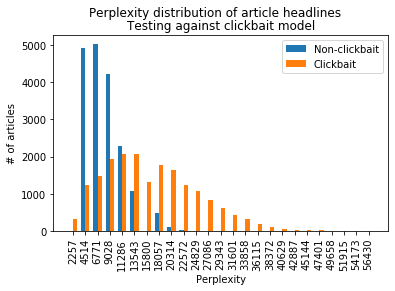

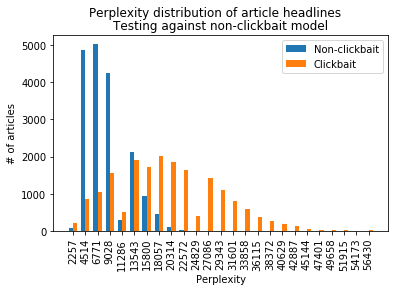

In [8]:
import matplotlib.pyplot as plt
import numpy as np

num_bins = 25
width = 0.35

def get_bins(num_bins, maximum, data) :
    bins = [0]*num_bins
    for p in data :
        if p < maximum :
            bins[int((p / maximum) * num_bins)] += 1
    return bins

def show_plot(c_perps, nc_perps, maximum, title) :
    c_bins = get_bins(num_bins, maximum, c_perps)
    nc_bins = get_bins(num_bins, maximum, nc_perps)

    ind = np.arange(num_bins)

    plt.bar(ind, nc_bins, width, label='Non-clickbait')
    plt.bar(ind+width, c_bins, width, label='Clickbait')
    plt.xlabel('Perplexity')
    plt.ylabel('# of articles')
    plt.suptitle('Perplexity distribution of article headlines')
    plt.title(title)
    plt.legend(loc='best')
    
    plt.xticks(ind + width / 2, (int(((i+1) / num_bins) * maximum) for i in range(num_bins)), rotation='vertical')
    plt.subplots_adjust(bottom=0.2)
    
    plt.show()

for ngram in range(1, 4) :
    print('N-gram:', ngram)
    
    cvc_perps = []; cvnc_perps = []
    ncvc_perps = []; ncvnc_perps = []
    maximum = 0
    
    c_model = language_model(ngram)
    c_model.train(open(train_clickbait_file, 'r').read())
    nc_model = language_model(ngram)
    nc_model.train(open(train_nonclickbait_file, 'r').read())
    
    correct = 0.0
    total = 0.0
    for line in open(test_clickbait_file, 'r').readlines() :
        line = line.strip()
        if line :
            c_perp = c_model.test(line)
            cvc_perps.append(c_perp)
            if c_perp > maximum :
                maximum = c_perp
            nc_perp = nc_model.test(line)
            cvnc_perps.append(nc_perp)
            if c_perp < nc_perp :
                correct += 1.0
            total += 1.0
    
    c_accuracy = correct / total
    print('Clickbait accuracy: {:.2f}%'.format(100.0*(c_accuracy)))

    correct = 0.0
    total = 0.0
    for line in open(test_nonclickbait_file, 'r').readlines() :
        line = line.strip()
        if line :
            nc_perp = nc_model.test(line)
            ncvnc_perps.append(nc_perp)
            if nc_perp > maximum :
                maximum = nc_perp
            c_perp = c_model.test(line)
            ncvc_perps.append(c_perp)
            if nc_perp < c_perp :
                correct += 1.0
            total += 1.0
    
    nc_accuracy = correct / total
    print('Non-clickbait accuracy: {:.2f}%'.format(100.0*(nc_accuracy)))
    print('Average accuracy: {:.2f}%'.format( 100*((c_accuracy + nc_accuracy) / 2.0) ))
    
    show_plot(cvc_perps, ncvc_perps, maximum, 'Testing against clickbait model')
    show_plot(cvnc_perps, ncvnc_perps, maximum, 'Testing against non-clickbait model')

## Discussion & Analysis

How we initially determined our accuracy was to split our clickbait and non-clickbait datasets into training and testing data, and run our models against what was sectioned off. After doing so we got a clickbait accuracy of over 99% and we assumed this was too good to be true. We ultimately decided to use an independent set of data in which to test our models on, and we were right about our initial 99% accuracy to be incorrect. Although we weren't far off. We found that it is possible, however, to use a language model to classify and categorize sentences against a large dataset and have it be accurate. Our new accuracy came out to be almost as high with 95.49% for clickbait data, and we were much more confident in this number.

From our findings of comparing the accuracy of each n-gram model, we found that unigrams were the most accurate with an amazing 86.48% accuracy. This is quite a bit different than our initial hypothesis. From what we've learned we assumed trigrams were going to give us the best accuracy, or at least come close to being similar to the bigram accuracy. This was far from the case as trigrams had an average of about a 50% acccuracy, so they weren't accurate at all. Our assumption as to why this occurs is because a lot of clickbait articles are so similar in the way they're written and the words they use that it's easy to find those common phrases in their n-gram frequency data. Non-clickbait articles aren't built the same way because they attempt to use a wider variety of phrases and idioms, and end up being less similar to other articles. 

After looking at our data, we've hypothesized that regular articles are becoming more like clickbait over time. There's a reason why clickbait has been as successful as it has, and that's because people can't resist curiosity. Bigger news organizations are slowly starting to adopt this strategy of getting users to click on your articles to get more traffic to their websites. This seems evident in our data because clickbait accuracy has always been around 95%, but non-clickbait accuracy is where our models stuggle. We believe that overtime it's simply going to get harder and harder to distinguish between clickbait and non-clickbait. 

## Conclusion

The speed of the program lends itself to be usable in a real world API because we want the program to able to calculate percentages in less than half a second, and it does accomplish this. However, even using unigrams, because they are the most accurate in their prediction capabilities, we still aren't completely confident that this model would be usable for a real browser plugin. We'd want the accuracy to be in at least the 90th percentile to work well, but I believe that given anough data we'd be able to increase our probabilities. 

## Bibliography

[1] https://people.mpi-sws.org/~achakrab/papers/chakraborty_clickbait_asonam16.pdf

[2] https://en.wikipedia.org/wiki/Language_model#n-gram

### Datasets

[3] About 16,000 clickbait and 16,000 non-clickbait headlines we used for our training model: https://github.com/bhargaviparanjape/clickbait/tree/master/dataset

[4] 1 million news article headlines from a reputable Australian news organization. We picked a random 18,128 of these articles for testing against our models: https://www.kaggle.com/therohk/million-headlines

[5] 3 million article headlines taken from The Examiner new orginization, which is notorious for clickbait news articles. We used a random 18,762 of these headlines for testing against our models: https://www.kaggle.com/therohk/examine-the-examiner/version/1

### Source Code

[6] https://github.com/CalebET/CS440-Project